# Simulates 20 trials for each one of the trajectories
## The results are saved into the base_dir to files following this template: 

### "States\_Torques\_movement"+str(pos\_i)+"\_LSM_"+str(run_i)+".gzpickle") or
### "States\_Torques\_movement"+str(pos\_i)+"\_LSM_"+str(run_i)+"_STP_ON.gzpickle")


## Which things I can change HERE:
1)Liquid's parameters from Joshi/Maass 2006 and Maass 2002.  
2)The amount of noise injected into the inputs. Right now I'm injecting +/- 2 directly into the indices of the input spikes instead of the noise into the weights according to Joshi/Maass 2006.  
3)STP: ON and OFF.  
4)Stratification or simply 30% random excitatory neurons instead.  
5)Width of the gaussian used to distribute the inputs into the liquid.  
6)Lambda value: I'm using 1.2 because Joshi/Maass 2006 sugest this. I could try something else.  
7)Noisy: different starting and background noise levels.  
8)Initial seed for the liquid's structure. I could change different seeds of even trying with a always random liquid's structure. If my_seed==0 the system uses a random liquid.  
9)Number of trials.  
10)Number of different trajectories.  


## Another possible experiment is using different training set. I could try shorter movements and also movements where the starting or final point is kept constant.

In [3]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

plt.rcParams['figure.figsize'] = 20, 10

import numpy
import sys
import save_load_file as slf

In [4]:
# Loads the modules and starts the object to be used with the parallel processing iPython stuff...

# Remember to execute at the shell: ipcluster start -n 4
# or from the iPython notebook interface!
# from IPython.parallel import Client
from ipyparallel import Client

# When using the ipython in my desktop, launch the cluster in the right profile :)
cli = Client()

# lbview = cli.load_balanced_view()
dview = cli[:]

# Brian Step-By-Step class
## This class alows the user to do step-by-step simulations using Brian WITHOUT having to generate the input spikes before the simulation starts. It's also useful because the simulation can last, idealy, forever without using a giant input spike list.

In [5]:
%%file step_by_step_brian.py

class step_by_step_brian_sim(object):
    '''
    Step-by-Step Brian Simulation (Nov/2014 - ricardo.deazambuja@plymouth.ac.uk)
    
    This class was created to make it easier to run a Brian simulation step-by-step, passing input spikes without 
    running out of memory or having to create the input spikes beforehand. It also makes the code more clear because
    you generate a separated function with your Brian simulation code. This function (here called simulation) receives:
    simulation(brian.defaultclock, brian)
    brian.defaultclock: Brian defaultclock to be used
    brian: the result of the command "import brian", so the user doesn't need to import Brian and have to use "brian.".
    And must return a tuple:
    (Input_layer, Output_layer, pop_objects, syn_objects, monitors_objects)
    Input_layer: is a SpikeGenerator
    Output_layer: the layer the user wants to output the spikes
    pop_objects: a list with all the NeuronGroups used
    syn_objects: a list with all the Synapses objects used
    monitors_objects: a list with all the Monitors or functions used with the @network_operation decorator
    
    At initialization the simulation step size (in ms) can be passed (default is 2).
    After the creation of the instance, calling the method "run_step(input_spike_index_list)" sends the spikes 
    to the simulation and simulates one step (according to the initialization).
    The method run_step returns returns a tuple:
    int(number_of_the_run), 
    float(current_simulation_time), 
    numpy.array(tuple(processed_received_spikes)),
    list(list(output_spikes)), 
    list(float(output_spikes_times))
    '''
    
    def __init__(self, simulation, init_step_size=2):
        print "Initializing the simulation..."
        self.step_size = init_step_size
        self._generator = self._return_generator(simulation)
        print "Initializing the simulation...Done"
        print "Call .run_step(input_spikes_list) to run one step of the simulation!"
    
    def run_step(self,input_spikes=None):
        '''
        Calls the generator .next and send methods and returns the spikes and times generated.
        '''
        self._generator.next() # Runs up to the first yield (where the generator waits for the .send method)
        ans = self._generator.send(input_spikes) # Sends the spikes and runs to the second yield 
                                                 #(where the generator returns the result of the simulation)
        return ans
    
    def _return_generator(self, simulation):
        '''
        Defines a simulation using a python generator.
        '''

        import brian
        import numpy

        print "Starting the simulation!"

        print "Reseting the Brian Simulation object...",
        brian.reinit() # This is only necessary when using the same enviroment over and over (like with iPython).
        print "Done!"

        clock_mult = self.step_size
        brian.defaultclock.dt = clock_mult*brian.ms
        
        print "Initial simulation time:", brian.defaultclock.t
        print "Simulation step:", brian.defaultclock.dt
        
        # Calls the user function with the Brian objects to be used in the simulation
        Input_layer, Output_layer, pop_objects, syn_objects, monitors_objects = simulation(brian.defaultclock, brian)

        output_spikes = []
        output_spikes_time = []

        # Every time spikes occur at the SpikeMonitor related to the output neuron group, this function is called
        def output_spikes_proc(spikes):
            if len(spikes):
                output_spikes.append(spikes.tolist()) # Saves the indexes of the neurons who generated spikes
                output_spikes_time.append(1000*float(brian.defaultclock.t)) # Converts and save the actual time in ms
                # The spike monitor and all this code could be replaced by the .get_spikes() method of neurongroups.
                # I need to check what is fastest way!

        OutputMonitor=brian.SpikeMonitor(Output_layer, record=False, function=output_spikes_proc)
        # Because it is not saving, the system is not going to run out of memory after a long simulation.
        
        net = brian.Network(pop_objects + syn_objects + monitors_objects + [OutputMonitor])

        r=0
        while True:
            spiketimes = yield # Receives the content from the Python generator method .send()          
            if spiketimes:
                spiketimes = [(i,brian.defaultclock.t) for i in spiketimes] # The spikes received are inserted as the last simulated time
                Input_layer.set_spiketimes(spiketimes)
            net.run(clock_mult*brian.ms) # I'm running one step each time this function is called
            r+=1
            yield (
                  r,
                  float(brian.defaultclock.t)*1000, 
                  numpy.array(Input_layer.get_spiketimes()).astype(dtype=numpy.float), # I'm doing this way to prove the spikes were received
                  output_spikes,
                  output_spikes_time 
                  )# After the .send method, the generator executes this line and stops here

            output_spikes=[] # Cleans the output_spikes list so only the last spikes generated are sent
            output_spikes_time=[] # Cleans the output_spikes list so only the last spikes generated are sent            
            
            # I'm using the .astype(numpy.float) because the arrays have Brian objects (units),
            # and I think using only floats the memory footprint can be smaller.

Overwriting step_by_step_brian.py


In [6]:
# import step_by_step_brian
# reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
# step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim

# Membrane low-pass filter class
## This class automates the process to read and generate the equivalent output of a low-pass membrane behaviour.

In [7]:
%%file membrane_lowpass_md.py

import numpy

class membrane_lowpass(object):
    
    def __init__(self, Number_of_Neurons, tau):
        '''
        Initializes the neuron membranes.
        Number_of_Neurons: total number of neurons to be simulated
        tau: time constant (in seconds)
        '''
        self.neurons = numpy.zeros(Number_of_Neurons)
        self.times = numpy.zeros(Number_of_Neurons)
        self.tau = tau
    
    def process_spikes(self, spikes, current_time):
        '''
        Processes the received spikes at the current time updating their membrane values.
        spikes: list with the indexes of the neurons who spiked.
        current_time: the time the neurons spiked (float)
        '''
        delta_t = current_time-self.times[spikes] # Calculates the difference between the last time they spiked
        current_values = self.neurons[spikes]*numpy.exp(-delta_t/self.tau) # Calculates the current values
        self.times[spikes]=numpy.ones(len(spikes))*current_time # Updates the last time they spiked
        self.neurons[spikes] = current_values + numpy.ones(len(spikes)) # Updates the neuron membrane values

    def check_values(self, current_time):
        '''
        Returns the current membrane values at the specified time.
        current_time: time used to calculate the membrane values.
        '''
        delta_t = current_time-self.times # Calculates the time since last spike
        return self.neurons*numpy.exp(-delta_t/self.tau) # Calculates the current values
        

Overwriting membrane_lowpass_md.py


In [8]:
# import membrane_lowpass_md
# reload(sys.modules['membrane_lowpass_md']) # Makes sure the interpreter is going to reload the module
# membrane_lowpass = membrane_lowpass_md.membrane_lowpass

# Change the parameters to set for Maass 2002 or Joshi/Maass 2006 parameters version.

In [9]:
%%file simulation_2DoF_Arm_md.py
# These variables I'm expecting to receive from outsite the namespace of this function
# using the func_globals dictionary. So it's necessary to 'create' them, or an error message
# is generated.
input_gain=0
STP_OFF=0
noisy=0
stratification=0
gaussian_pop=0
w_SD=0
i_noiseA=0
offset_noise=0
initial_volt=0
random_reset=0
Net_shape=0
Number_of_input_layers=0
Number_of_neurons_inputs=0
lbd_value=0
noisy_currents=0
noisy_input_weights=0
noisy_input=0
input_noise_level=0
AII=0
AIE=0
AEI=0
AEE=0

killed_neurons=[] # indices of the liquid's neurons that should not spike

def simulation_2DoF_Arm(brian_clock, brian):
    """    
    #############################################################################
    The variables:
    my_seed: value (integer) used as the random seed to keep the liquid structure the same (or not)
    input_gain: the multiplier (float) used within the input layer
    noisy: 0=>always uses my_seed to start the random generator; 1=>uses the default random state every run
    gaussian_pop: 1=>gaussian distribution as the input layers gains; 0=>random weights (just like in Maass's papers)
                 -1=>gaussian distribution with an offset noise
    w_SD: standard deviation of the gaussian used to distribute the input weights
    stratification: 0=>no stratification; 1=>stratified inputs
    STP_OFF: True=>No STP; False=>STP
    Must be set from outside using the .func_globals dictionary. Example:
    simulation_2DoF_Arm.func_globals['my_seed']=93200
    #############################################################################
    """
    
    import numpy # I could use "brian." because Brian imports numpy, but I prefer not to.
    import time
    import sys

#
#     THE VARIABLES BELOW MUST BE SET OUTSIDE OR THE SIMULATION IS NOT GOING TO WORK!
#
#     Example:
#     simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
#     simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
#     simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
#     simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
#     simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
#     simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
#     simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

#     simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0             # amplitude (dimensionless) of the random currents (updated every time step).
#     simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5,14.5) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

#     simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

#     simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
#     simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
#     simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
#     simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
#     simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

#     simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
#     simulation_2DoF_Arm.func_globals['noisy_input_weights'] = True # Injects noise into the input weights
#     simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
#     simulation_2DoF_Arm.func_globals['input_noise_level'] = 0.1 # 1/SNR

      # STP parameters
#     simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
#     simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
#     simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
#     simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2

    Number_of_neurons_lsm=Net_shape[0]*Net_shape[1]*Net_shape[2] # Just to avoid calculating this everytime it's used

    
    # These lines make easier to use the Brian objects without the "brian." at the beginning
    ms = brian.ms
    mV = brian.mV
    nA = brian.nA
    nF = brian.nF
    NeuronGroup = brian.NeuronGroup
    SpikeGeneratorGroup = brian.SpikeGeneratorGroup
    Synapses = brian.Synapses
    SpikeMonitor = brian.SpikeMonitor
    network_operation = brian.network_operation 
    defaultclock = brian.defaultclock

    if my_seed!=0:
        # This seed can guarantee that the liquid is going to have the same structure because this object 
        # is passed to the lsm_connections_probability module.
        liq_rs = numpy.random.RandomState(my_seed) # this is the random state used within the liquid structure generation
    else:
        liq_rs = numpy.random.RandomState() #random liquid
    
    import lsm_connections_probability # Creates the 3D Grid and the connections according to Maass 2002
    reload(sys.modules['lsm_connections_probability']) # Makes sure the interpreter is going to reload the module
    lm = lsm_connections_probability

    import lsm_dynamical_synapses_v1 # Creates the dynamical synapses according to Maass 2002 and using the output 
                                     # from the lsm_connections_probability    
    reload(sys.modules['lsm_dynamical_synapses_v1']) # Makes sure the interpreter is going to reload the module
    ls = lsm_dynamical_synapses_v1

    
    # Here I'm creating the random state for the rest of the simulation
    # This way I can have a fixed liquid structure, but with all the other noisy sources.
    if noisy or (my_seed==0):
        sim_rs = numpy.random.RandomState()
    else:
        sim_rs = numpy.random.RandomState(my_seed)

    if noisy_input or (my_seed==0):
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(my_seed)
        
    initial_time = time.time()

    print "Initial time:",initial_time

    print "#"*78
    print "#"*78
    print "Liquid State Machine - 2 DoF arm experiments!"
    print "#"*78
    print "#"*78


    defaultclock = brian_clock  # Receives the clock from the step-by-step simulator
                                # I'm setting it to the defaultclock because all connected NeuronGroups 
                                # must use the same clock.


    lsm_3dGrid_flat = numpy.zeros(Number_of_neurons_lsm) 
    # This creates a numpy 1D array with 'Number_of_neurons_lsm' positions
    # I'm using a numpy array to be able to use the reshape method to 
    # change from 1D (vector) to 3D (matrix)


    def randon_connections_gen(Number_of_neurons, ratio, number=None):
        '''
        Generate the random neuron indexes list according to the number of neurons and the ratio
        '''
        # List used to generate the randoms 'ratio' indexes for the Liquid
        l_range = range(Number_of_neurons)

        # Generates the random "indexes" of the flattened version of the 3DGrid.
        # At each iteration one random item is extracted from l_range and inserted in connection_index.
        # This is the way I've found to sample without repetitions.
        # - Another way is using the shuffle from numpy and then grabbing the first N values!      
        if number==None:
          connection_index = [l_range.pop(liq_rs.randint(0,len(l_range))) for i in range(int(Number_of_neurons*ratio))] 
        else:
          connection_index = [l_range.pop(liq_rs.randint(0,len(l_range))) for i in range(int(number))] 
        connection_index.sort() #This is only useful to make easier to human beings to read the list :)

        return connection_index


    #
    # Number of Inhibitory and Excitatory neurons - LIQUID - 20% of the total neurons
    inhibitory_index_L = randon_connections_gen(Number_of_neurons_lsm, 0.2)


    # This is the dictionary that has all the connections parameters according to Maass 2002.
    # It is necessary to create the 3D connections and the STP configuration matrices
    # E=>1 (excitatory) and I=>0 (inhibitory)
    # Ex.: (0,0) => II
    # Dynamical Synapses Parameters (STP):
    Connections_Parameters={
                  (0,0):[ # II
                          0.1,       # CGupta=0.1        # Parameter used at the connection probability - from Maass2002 paper
                          0.32,      # UMarkram=0.32     # Use (U) - Parameter used at the Dynamic Synapse - from Maass2002 paper
                          0.144,     # DMarkram=0.144    # Time constant for Depression (tau_rec) - used at the Dynamic Synapse - from Maass2002 paper                    
                          0.06,      # FMarkram=0.06     # Time constant for Facilitation (tau_facil) - used at the Dynamic Synapse - from Maass2002 paper
                          AII,       # AMaass=2.8        # (nA) In the Maass2002 paper the value is negative, but because I need a positive scale (random.normal parameter) and there is a negative sign in front of the abs function I changed this to positive
                          0.8        # Delay_trans = 0.8 # In Maass paper the transmission delay is 0.8 to II, IE and EI        
                      ],
                  (0,1):[ # IE
                          0.4,    # CGupta=0.4
                          0.25,   # UMarkram=0.25
                          0.7,    # DMarkram=0.7
                          0.02,   # FMarkram=0.02
                          AIE,    # AMaass=3.0 #in the Maass2002 paper the value is negative, but because I need a positive scale (random.normal parameter) and there is a negative sign in front of the abs function I changed this to positive
                          0.8     # Delay_trans = 0.8 # in Maass paper the transmission delay is 0.8 to II, IE and EI
                      ],
                  (1,0):[ # EI
                          0.2,    # CGupta=0.2
                          0.05,   # UMarkram=0.05
                          0.125,  # DMarkram=0.125
                          1.2,    # FMarkram=1.2
                          AEI,    # AMaass=1.6
                          0.8     # Delay_trans = 0.8 # in Maass paper the transmission delay is 0.8 to II, IE and EI
                      ],
                  (1,1):[ # EE
                          0.3,    # CGupta=0.3 
                          0.5,    # UMarkram=0.5
                          1.1,    # DMarkram=1.1
                          0.05,   # FMarkram=0.05
                          AEE,    # AMaass=1.2 #scaling parameter or absolute synaptic efficacy or weight - from Maass2002 paper
                          1.5     # Delay_trans = 1.5 # in Maass paper the transmission delay is 1.5 to EE connection
                      ]
                  }


    # Utilizes the functions in the lsm_connections_probability.py
    # =>output = {'exc':connections_list_exc,'inh':connections_list_inh, '3Dplot_a':positions_list_a, '3Dplot_b':positions_list_b}
    # connections_list_exc= OR connections_list_inh=
      # ((i,j), # PRE and POS synaptic neuron indexes
      # pconnection, # probability of the connection
      # (W_n, U_ds, D_ds, F_ds), # parameters according to Maass2002
      # Delay_trans, # parameters according to Maass2002
      # connection_type)

    # Generate the connections matrix inside the Liquid (Liquid->Liquid) - according to Maass2002
    #
    print "Liquid->Liquid connections..."

    print "Generating the Liquid->Liquid connections..."
    output_L_L = lm.generate_connections(lsm_3dGrid_flat, inhibitory_index_L, Net_shape, 
                                      CParameters=Connections_Parameters, lbd=lbd_value, randomstate=liq_rs) 
                                    # lbd controls the connections
                                    # randomstate receives a numpy.random.RandomState object, or automatically sets a random one.
                                                                    
    

    print "Liquid->Liquid connections...Done!"

    
    #
    # These are the cell (neuron) parameters according to Maass 2002
    #
    cell_params_lsm = {'cm'          : 30.0,    # [nF]  Capacitance of the membrane 
                                                # =>>>> MAASS PAPER DOESN'T MENTION THIS PARAMETER DIRECTLY
                                                #       but the paper mention a INPUT RESISTANCE OF 1MEGA Ohms and tau_m=RC=30ms, so cm=30nF
                       'tau_m'       : 30.0,    # [ms] Membrane time constant => Maass2002
                       'tau_refrac_E': 3.0,     # [ms] Duration of refractory period - 3mS for EXCITATORY => Maass2002
                       'tau_refrac_I': 2.0,     # [ms] Duration of refractory period - 2mS for INHIBITORY => Maass2002
                       'tau_syn_E'   : 3.0,     # [ms] Decay time of excitatory synaptic current => Maass2002
                       'tau_syn_I'   : 6.0,     # [ms] Decay time of inhibitory synaptic current => Maass 2002
                       'v_reset'     : 13.5,    # [mV] Reset potential after a spike => Maass 2002
                       'v_rest'      : 0.0,     # [mV] Resting membrane potential => Maass 2002
                       'v_thresh'    : 15.0,    # [mV] Spike threshold => Maass 2002
                       'i_noise'     : i_noiseA # [nA] Used in Joshi/Maass 2005: mean 0 and SD=1nA; Maass 2002=>SD=0.2nA
                    }

    offset_cur = (offset_noise[0],offset_noise[1])  # Values for the uniform distribution of constant offset currents
    init_volt = (initial_volt[0],initial_volt[1])   # Values for the uniform distribution of initial membrane voltages
    rand_res = (random_reset[0],random_reset[1])    # Values for the uniform distribution of constant random resets


    # IF_curr_exp - MODEL EXPLAINED
    # Leaky integrate and fire model with fixed threshold and
    # decaying-exponential post-synaptic current. 
    # (Separate synaptic currents for excitatory and inhibitory synapses)
    lsm_neuron_eqs='''
      dv/dt  = (ie + ii + i_offset + i_noise)/c_m + (v_rest-v)/tau_m : mV
      die/dt = -ie/tau_syn_E                : nA
      dii/dt = -ii/tau_syn_I                : nA
      tau_syn_E                             : ms
      tau_syn_I                             : ms
      tau_m                                 : ms
      c_m                                   : nF
      v_rest                                : mV
      i_offset                              : nA
      i_noise                               : nA
      '''



    ########################################################################################################################
    #
    # LIQUID - Setup
    #
    print "LIQUID - Setup..."

    # Creates a vector with the corresponding refractory period according to the type of neuron (inhibitory or excitatory)
    # IT MUST BE A NUMPY ARRAY OR BRIAN GIVES CRAZY ERRORS!!!!!
    refractory_vector = [ cell_params_lsm['tau_refrac_E'] ]*Number_of_neurons_lsm # fills the list with the value corresponding to excitatory neurons
    for i in range(Number_of_neurons_lsm):
        if i in inhibitory_index_L:
            refractory_vector[i]=cell_params_lsm['tau_refrac_I'] # only if the neuron is inibitory, changes the refractory period value!
    refractory_vector=numpy.array(refractory_vector)*ms # Here it is converted to a NUMPY ARRAY
    

    
    # This is the population (neurons) used exclusively to the Liquid (pop_lsm).
    pop_lsm = NeuronGroup(Number_of_neurons_lsm, model=lsm_neuron_eqs, 
                                                 threshold=cell_params_lsm['v_thresh']*mV, 
                                                 reset='v=sim_rs.uniform(rand_res[0],rand_res[1])*mV', 
                                                 refractory=refractory_vector, 
                                                 max_refractory=max(cell_params_lsm['tau_refrac_E']*ms, 
                                                                    cell_params_lsm['tau_refrac_I']*ms))
#     else:
#         print "Noisy resets OFF!"
#         # This is the population (neurons) used exclusively to the Liquid (pop_lsm).
#         pop_lsm = NeuronGroup(Number_of_neurons_lsm, model=lsm_neuron_eqs, 
#                                                      threshold=cell_params_lsm['v_thresh']*mV, 
#                                                      reset=cell_params_lsm['v_reset']*mV,
#                                                      refractory=refractory_vector, 
#                                                      max_refractory=max(cell_params_lsm['tau_refrac_E']*ms, 
#                                                                         cell_params_lsm['tau_refrac_I']*ms))


    # Here I'm mixing numpy.fill with the access of the state variable "c_m" in Brian (because Brian is using a numpy.array)
    # Sets the value of the capacitance according to the cell_params_lsm (same value to all the neurons)
    pop_lsm.c_m.fill(cell_params_lsm['cm']*nF)


    # Sets the value of the time constant RC (or membrane constant) according to the cell_params_lsm (same value to all the neurons)
    pop_lsm.tau_m.fill(cell_params_lsm['tau_m']*ms)

    # Sets the fixed i_offset current.
    # The i_offset current is random, but never changes during the simulation.
    # This current, according to Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
    # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe is to avoid too many spikes without inputs...
    pop_lsm.i_offset=sim_rs.uniform(offset_cur[0],offset_cur[1], Number_of_neurons_lsm)*nA

    pop_lsm.tau_syn_E.fill(cell_params_lsm['tau_syn_E']*ms) # (same value to all the neurons)
    pop_lsm.tau_syn_I.fill(cell_params_lsm['tau_syn_I']*ms) # (same value to all the neurons)

    pop_lsm.v_rest.fill(cell_params_lsm['v_rest']*mV) # (same value to all the neurons)

    # This current changes (randomly) at each time step (here is only the initialization).
    pop_lsm.i_noise=sim_rs.normal(loc=0, scale=cell_params_lsm['i_noise'],size=Number_of_neurons_lsm)*nA

    
    # Sets the initial membrane voltage. Doesn't change during the simulation.
    # According to Maass 2002, this voltage should be drawn from a uniform distr [13.5mV,15.0mV]
    # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)
    pop_lsm.v=sim_rs.uniform(init_volt[0],init_volt[1], Number_of_neurons_lsm)*mV

    #Kills neurons by setting their initial voltage to a crazily LOW value
    pop_lsm.v[killed_neurons]=-1E12*mV
    
    #
    # Loading or creating the Synapses objects used within the Liquid
    print "Liquid->Liquid connections..."

    syn_lsm_obj = ls.LsmConnections(pop_lsm, pop_lsm, output_L_L, nostp=STP_OFF)

    # Generates the Liquid->Liquid - EXCITATORY synapses
    syn_lsm_exc = syn_lsm_obj.create_synapses('exc')

    # Generates the Liquid->Liquid - INHIBITORY synapses
    syn_lsm_inh = syn_lsm_obj.create_synapses('inh')
    

    print "Liquid->Liquid connections...Done!"

    total_number_of_connections_liquid = len(syn_lsm_exc) + len(syn_lsm_inh)

    print "Number of excitatory synapses in the Liquid: " + str(len(syn_lsm_exc)) # DEBUG to verify if it is working
    print "Number of inhibitory synapses in the Liquid: " + str(len(syn_lsm_inh)) # DEBUG to verify if it is working

    # To understand what is being returned:
    # pop_lsm: it is necessary to connect the neuron network with the rest of the world
    # [syn_lsm_obj, syn_lsm_exc, syn_lsm_inh]: to include these objects at the simulation (net=Net(...); net.run(total_sim_time*ms)); 
    # It is a list because is easy to concatenate lists :D

    print "LIQUID - Setup...Done!"

    #
    # End of the LIQUID - Setup
    ########################################################################################################################



    ########################################################################################################################
    #
    # INPUT - Setup
    #
    print "INPUT - Setup..."
  
    spiketimes = [] # The spikes are going to be received during the simulation, 
                    # so this is always an empty list when using the step_by_step_brian_sim!
    
    # I'm using only one big input layer because Brian docs say it is better for the performance
    SpikeInputs = SpikeGeneratorGroup(Number_of_input_layers*Number_of_neurons_inputs, spiketimes)
    

    #
    #
    # Here the synapses are created. The synapses created are ALWAYS excitatory because it is 
    # connecting through 'ie' in the neuron model!

    syn_world_Input = Synapses(SpikeInputs, pop_lsm,
                                         model='''w : 1''',
                                         pre='''ie+=w''')


    weights_input_liquid = [] # remember that the weights must follow the same order of the creation of synapses


    def gaussian(lamb,n,nt):
        '''
        Generates a gaussian centered at 'n'
        '''
#         return input_gain*(1/(lamb*numpy.sqrt(2*numpy.pi)))*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #Energy normalized version
        return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization
  
    def simple_inputs(*args):
        '''
        This function ignores the arguments and return a random value from a gaussian distribution with mean input_gain and SD=input_gain/2.0
        '''
        return (abs(sim_rs.normal(loc=input_gain, scale=input_gain/2.0))) # The "abs" function is to guarantee all inputs are excitatories!    

    def gaussian_noise(lamb,n,nt):
        '''
        Generates a gaussian centered at 'n' with a background noise (1/3 of the amplitude)
        '''
        return 3*input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) + (abs(sim_rs.normal(loc=input_gain, scale=input_gain/2.0)))


    # Verifies the user selection and sets the proper weight generation function.
    if gaussian_pop==1:
        weight_func = gaussian
    elif gaussian_pop==0:
        weight_func = simple_inputs
    else:
        weight_func = gaussian_noise
        


    if stratification==0:
        # List with the indexes of all the excitatory neurons in the liquid
        excitatory_index_L = [i for i in range(Number_of_neurons_lsm) if i not in inhibitory_index_L]

        # Here I connect the input neurons only to excitatories neurons in the liquid:
        sim_rs.shuffle(excitatory_index_L) # Shuffles the excitatory index vector.
        rand_connections = excitatory_index_L[:int(len(excitatory_index_L)*0.3)] # Gets randomly 30% of the excitatory connections

        # Here I connect the input neurons to any type of neurons in the liquid:
        # rand_connections = randon_connections_gen(Number_of_neurons_lsm, 0, number=int(Number_of_neurons_lsm*0.3)) # generates random connections to 30% of the neurons in the liquid!

        # Goes through the liquid to generate the proper connections
        for inp in range(Number_of_input_layers):
            for i in range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)):
                for j,ji in zip(rand_connections,range(len(rand_connections))):
                    syn_world_Input[i,j] = True # So it is one-to-random NoIN neurons, each input neuron is connect to all the "input layer" of the liquid.
                    # All inputs have the same connections to the Liquid (I would say that they are all connect to the input layer of the liquid)
                    # If they are all connected to the same neurons, seems to me that is less probable that the readout is going to learn
                    # only to filter the input...
                    centre_position=(i-(inp*Number_of_neurons_inputs))*(len(rand_connections)-1)/float(Number_of_neurons_inputs)
                    weights_input_liquid.append(weight_func(w_SD,centre_position,ji)*nA)
    else:

        # Goes through the liquid to generate the proper connections, but dividing the liquid into the same number of input layers
        liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))
        for inp in range(Number_of_input_layers):
            for i in range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)):
                for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),range(liquid_input_layer_size)):
                    if j not in inhibitory_index_L:
                        syn_world_Input[i,j] = True
                        centre_position=(i-(inp*Number_of_neurons_inputs))*(liquid_input_layer_size-1)/float(Number_of_neurons_inputs)
                        weights_input_liquid.append(weight_func(w_SD,centre_position,ji)*nA)
                        



  
    weights_input_liquid = numpy.array(weights_input_liquid)
    
    
    syn_world_Input.w = weights_input_liquid
    syn_world_Input.delay=0*ms

    print "INPUT - Setup...Done!"

    #
    # End of the INPUT - Setup (creation of the connections between the Poisson input and the Liquid!)
    #
    ########################################################################################################################


    # Generates the noisy current at each time step (as seen in Joshi/Maass 2005)
    @network_operation(clock=defaultclock)
    def generate_i_noise():
        if noisy_currents:
            # These are the noise currents inside each liquid's neuron
            pop_lsm.i_noise=cell_params_lsm['i_noise']*sim_rs.normal(loc=0,scale=1,size=Number_of_neurons_lsm)*nA
        
        # This is the noise inserted into the inputs (according to my interpretation of Joshi's thesis, pdf page 54)
#         syn_world_Input.w[:]=weights_input_liquid+(1E-5*sim_rs.normal(loc=0,scale=1,size=len(weights_input_liquid)))
        # => weights_input_liquid HAS DIMENSION 1E-9.
        # => the added noise HAS DIMENSION 1E-5.
        # SNR = 20*numpy.log((1E-9)/(1E-5))/numpy.log(10) ~ -80dB!!!!
        # Or the noise power is 10**8 times stronger than the signal power itself!!!!!
        # IMHO the information is completely lost in this case and the liquid would be a super 
        # regenerative filter to be able to deal with such a SNR.
        
        if noisy_input_weights:
            # This is my new version where the noise level can be controlled
            syn_world_Input.w[:]=weights_input_liquid+((input_noise_level*input_gain)*input_rs.normal(loc=0,scale=1,size=len(weights_input_liquid))*nA)        


    populations_sim = [pop_lsm, SpikeInputs]

    synapses_sim = [syn_lsm_exc, syn_lsm_inh, syn_world_Input]

    monitors_sim = [generate_i_noise] 

    Input_layer, Output_layer, pop_objects, syn_objects, monitors_objects = SpikeInputs, pop_lsm, populations_sim, synapses_sim, monitors_sim

    print "Setup time:", time.time()-initial_time
    
    # Returns these objects to be used with the step_by_step_brian_sim class
    return Input_layer, Output_layer, pop_objects, syn_objects, monitors_objects

Overwriting simulation_2DoF_Arm_md.py


# Main functions to the 2 joint arm simulation

In [10]:
from simulation_2DoF_Arm_physics import *
reload(sys.modules['simulation_2DoF_Arm_physics']) # Makes sure the interpreter is going to reload the module

<module 'simulation_2DoF_Arm_physics' from 'simulation_2DoF_Arm_physics.pyc'>

# Start of the simulation!

In [11]:
def generates_input_spikes_lsm(delta_t = 200):
    # First the arm parameters according to Joshi/Maass paper
    aparams = {
        'l1' : 0.5, # metres
        'l2' : 0.5,
        'lc1' : 0.25,
        'lc2' : 0.25,
        'm1' : 1.0, # kg
        'm2' : 1.0,
        'i1' : 0.03, # kg*m*m
        'i2' : 0.03
    }

    # Total time spent during the movement (in seconds)
    MT = 0.5 # 500ms

    # Simulation time step (in seconds)
    time_step = 2/1000.0 # 2ms

    # Number of neurons at each input layer (defines the resolution of the system)
    Ninput = 50

    t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

    # Reads all the experiments (generated using the 2DofArm_simulation_data_generator.ipynb) 
    # to check which range of torques is necessary to control the arm.

    # These values are based ONLY in the "number_of_trajectories" trajectories used!
    torques_all_1 = numpy.array([]);
    torques_all_2 = numpy.array([]);
    for i in xrange(1,number_of_trajectories+1):
        states,torques = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(i)+".gzpickle")
        torques_all_1 = numpy.concatenate((torques_all_1,torques[:,0])) # torques joint 1
        torques_all_2 = numpy.concatenate((torques_all_2,torques[:,1])) # torques joint 2

    # Creates the 50 possible discrete values of torques for each joint (probably they will be different)
    torques_values_1=numpy.linspace(torques_all_1.min(),torques_all_1.max(),num=50)
    torques_values_2=numpy.linspace(torques_all_2.min(),torques_all_2.max(),num=50)

    # Creates the 50 possible discrete values of angles for each joint
    teta1_values=numpy.linspace(-numpy.pi/6,numpy.pi,num=50)
    teta2_values=numpy.linspace(0,numpy.pi,num=50)

    # These are the 50 possible values that the input neurons will represent (x,y) 
    x_values=numpy.linspace(-1,1,num=50)
    y_values=numpy.linspace(-1,1,num=50)

#     # These are the normalized starting positions
#     xstart_normalized =  x_values[abs(x_values-xstart).argmin()]
#     ystart_normalized =  y_values[abs(y_values-ystart).argmin()]

    # The data file below was created using the iPython notebook: "2DofArm_simulation_data_generator.ipynb"
    states,torques = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(tji)+".gzpickle")

    # These are the normalized torques according to the minimum and maximum torques available in the set (experiments)
    torques_normalized = numpy.array([[torques_values_1[abs(torques_values_1-xy[0]).argmin()], torques_values_2[abs(torques_values_2-xy[1]).argmin()]] for xy in torques])

    # These are the normalized teta1 and teta2 angles in a matrix format (numpy.array)
    states_normalized = numpy.array([[teta1_values[abs(teta1_values-st[0]).argmin()], teta2_values[abs(teta2_values-st[1]).argmin()]] for st in states])

    # HERE SEEMS TO BE THE ONLY PLACE I COULD INJECT AN "ANALOG" NOISE INTO THE INPUTS.

    # Indexes of the normalized torque values to use in the LSM simulation 
    # Remember: the LSM has only 50 neurons to encode each variable and the LSM receives only indexes!
    torques_normalized_idx = numpy.array([[abs(torques_values_1-xy[0]).argmin(), abs(torques_values_2-xy[1]).argmin()] for xy in torques])

    # Indexes of the normalized joint angle values to use in the LSM simulation 
    joint_states_idx = numpy.array([[abs(teta1_values-xy[0]).argmin(), abs(teta2_values-xy[1]).argmin()] for xy in states[:,[0,1]]])
    
    # The input (one big neurongroup with 300 neurons) will be divided like this:
    # 6 groups of 50 neurons.
    # - Group 1: xdest => offset:0
    # - Group 2: ydest => offset:50
    # - Group 3: teta1 => offset:100
    # - Group 4: teta2 => offset:150
    # - Group 5: tau1  => offset:200
    # - Group 6: tau2  => offset:250

    #
    # Generates the input values used in the LSM simulation.
    #
    
    ############# Using ONLY the initial (start) position
    # Indexes of the normalized INITIAL position values to use in the LSM simulation
    # xstart_idx =  abs(x_values-xstart).argmin()
    # ystart_idx =  abs(y_values-ystart).argmin()
    
    # x_lsm = xstart_idx + 0
    # y_lsm = ystart_idx + 50    

    ############# Using ONLY the final (dest) position
    # Indexes of the normalized FINAL position values to use in the LSM simulation    
    xdest_idx =  abs(x_values-xdest).argmin()
    ydest_idx =  abs(y_values-ydest).argmin()    
    
    x_lsm = xdest_idx + 0
    y_lsm = ydest_idx + 50
    
    
    teta1_lsm = joint_states_idx[:,0] + 100
    teta2_lsm = joint_states_idx[:,1] + 150
    tau1_lsm = torques_normalized_idx[:,0] + 200
    tau2_lsm = torques_normalized_idx[:,1] + 250

#     delta_t = 200 # Time delay imposed to the joint angles - proprioceptive (in ms)
    delta_t_idx = int(delta_t/(1000*time_step)) # Number of steps the delay (delta_t) takes

    input_spikes_pos = [[x_lsm, y_lsm]]

    if delta_t_idx != 0:
        input_spikes_teta = [[]]
    else:
        input_spikes_teta = [[teta1_lsm[0], teta2_lsm[0]]]
        
    input_spikes_tau = [[tau1_lsm[0], tau2_lsm[0]]]
    
    if delta_t_idx!=0:
        delta_t_idx_counter = 1 # It's 1 because input_spikes already has one set of values
    else:
        delta_t_idx_counter = 0

    for idx in range(1, len(tau1_lsm)):
        if delta_t_idx_counter==delta_t_idx or delta_t_idx==0:
            # Here is where I insert the proprioceptive information about the joint angles after the delta_t time
            input_spikes_pos.append([x_lsm, y_lsm])
            input_spikes_teta.append([teta1_lsm[idx-delta_t_idx_counter], teta2_lsm[idx-delta_t_idx_counter]])
            input_spikes_tau.append([tau1_lsm[idx], tau2_lsm[idx]])
        else:
            input_spikes_pos.append([x_lsm, y_lsm])
            input_spikes_teta.append([])
            input_spikes_tau.append([tau1_lsm[idx], tau2_lsm[idx]])        
            delta_t_idx_counter+=1

    input_spikes = (input_spikes_pos,input_spikes_teta,input_spikes_tau)
    return input_spikes

# Template

In [12]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0             # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5,14.5) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 10E-5 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.        
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [13]:
# base_dir = "2DofArm_simulation_data_xx"
# sim_set = "set_xx"


# total_trials = 100 # total number of trials

# trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

# number_of_trajectories = len(trajectories)

# for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

#     xstart,ystart = positions[0]
#     xdest,ydest = positions[1]

#     input_spikes = generates_input_spikes_lsm()

#     print "Trajectory Number:",tji
#     %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

# Set XX - WITH STP

In [21]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/100     # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/100,14.5/100) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 0 # 1/SNR
    
    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            if len(iteta):
                simulated_values.append(s.run_step([ipos[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),ipos[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+[iteta[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),iteta[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
            else:
                simulated_values.append(s.run_step([ipos[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),ipos[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [22]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_xx"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
CPU times: user 37.3 s, sys: 2.39 s, total: 39.7 s
Wall time: 6min 39s
Trajectory Number: 2
CPU times: user 37.2 s, sys: 2.32 s, total: 39.5 s
Wall time: 6min 34s
Trajectory Number: 3
CPU times: user 37.2 s, sys: 2.28 s, total: 39.5 s
Wall time: 6min 37s
Trajectory Number: 4
CPU times: user 37.3 s, sys: 2.17 s, total: 39.5 s
Wall time: 6min 36s


# Set YY - WITHOUT STP

In [23]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=True      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/100     # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/100,14.5/100) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 0 # 1/SNR
    
    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            if len(iteta):
                simulated_values.append(s.run_step([ipos[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),ipos[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+[iteta[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),iteta[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
            else:
                simulated_values.append(s.run_step([ipos[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),ipos[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [24]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_yy"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
CPU times: user 36.8 s, sys: 2.17 s, total: 38.9 s
Wall time: 6min 31s
Trajectory Number: 2
CPU times: user 37 s, sys: 1.96 s, total: 38.9 s
Wall time: 6min 32s
Trajectory Number: 3
CPU times: user 37.1 s, sys: 2.17 s, total: 39.3 s
Wall time: 6min 34s
Trajectory Number: 4
CPU times: user 37.2 s, sys: 2.2 s, total: 39.4 s
Wall time: 6min 33s


# Set 00

In [14]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/100     # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/100,14.5/100) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 0 # 1/SNR
    
    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [15]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_00"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
CPU times: user 37.8 s, sys: 2.55 s, total: 40.4 s
Wall time: 6min 43s
Trajectory Number: 2
CPU times: user 38.5 s, sys: 2.57 s, total: 41 s
Wall time: 6min 46s
Trajectory Number: 3
CPU times: user 38.4 s, sys: 2.72 s, total: 41.1 s
Wall time: 6min 43s
Trajectory Number: 4
CPU times: user 38.2 s, sys: 2.37 s, total: 40.6 s
Wall time: 6min 43s


# Set 01

In [13]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/10             # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/10,14.5/10) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 10E-5 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.        
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [14]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_01"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
CPU times: user 38.5 s, sys: 2.52 s, total: 41.1 s
Wall time: 6min 45s
Trajectory Number: 2
CPU times: user 37.9 s, sys: 2.68 s, total: 40.6 s
Wall time: 6min 37s
Trajectory Number: 3
CPU times: user 38.6 s, sys: 2.34 s, total: 40.9 s
Wall time: 6min 42s
Trajectory Number: 4
CPU times: user 38.5 s, sys: 2.46 s, total: 40.9 s
Wall time: 6min 43s


# Set 02

In [ ]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0             # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5,14.5) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 10E-5 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.        
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    
    
    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [ ]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_02"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
CPU times: user 38.5 s, sys: 2.48 s, total: 41 s
Wall time: 6min 41s
Trajectory Number: 2
CPU times: user 38.7 s, sys: 2.41 s, total: 41.1 s

# Set 03

In [ ]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:

    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=True      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0     # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5,14.5) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 0 # 1/SNR
    
    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [ ]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_03"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

# Set 04

In [ ]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=2*3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0     # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5,14.5) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 0 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this. 
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [ ]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_04"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

# Set 05

In [ ]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=.5*3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0     # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5,14.5) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 0 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this. 
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [ ]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_05"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

# Set 06

In [ ]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/10             # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/10,14.5/10) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 10E-5 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.        
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [10]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_06"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=20000)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
Trajectory Number: 2
Trajectory Number: 3
Trajectory Number: 4


# Set 07

In [16]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/10             # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/10,14.5/10) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 10E-5 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.        
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+iteta+[itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [17]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_07"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=0)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
CPU times: user 39.2 s, sys: 2.53 s, total: 41.7 s
Wall time: 6min 42s
Trajectory Number: 2
CPU times: user 38.4 s, sys: 2.38 s, total: 40.8 s
Wall time: 6min 38s
Trajectory Number: 3
CPU times: user 39.5 s, sys: 2.77 s, total: 42.3 s
Wall time: 6min 55s
Trajectory Number: 4
CPU times: user 39.1 s, sys: 2.77 s, total: 41.9 s
Wall time: 6min 51s


# Set 08

In [12]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/10             # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/10,14.5/10) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 10E-5 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.        
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

#################################################################################################################
# HERE THE TETAS (PROPRIOCEPTIVE JOINT ANGLES FEEDBACK) ARE RECEIVING NOISE AS THE TAUS.
# IPOS NEVER RECEIVES NOISE BECAUSE I WANT TO MAKE THE NETWORK LEARN HOW TO REACH THAT POSITION.
# NOISE IS ONLY USED WHEN A VARIABLE IS FED BACK TO THE NETWORK (HENCE, MAKING IT ROBUST TO SMALL DEVIATIONS).
#################################################################################################################
    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            simulated_values.append(s.run_step(ipos+\
                                               [iteta[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),iteta[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+\
                                               [itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [13]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_08"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=0)

    print "Trajectory Number:",tji
    %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
CPU times: user 40.4 s, sys: 2.47 s, total: 42.9 s
Wall time: 6min 43s
Trajectory Number: 2
CPU times: user 39.1 s, sys: 2.51 s, total: 41.7 s
Wall time: 6min 44s
Trajectory Number: 3
CPU times: user 39.4 s, sys: 2.59 s, total: 42 s
Wall time: 6min 50s
Trajectory Number: 4
CPU times: user 39.4 s, sys: 2.53 s, total: 42 s
Wall time: 6min 45s


# Set 09

In [11]:
@dview.parallel(block=True)
def run_simulations_2(sim_num): 
    import numpy
    import time
    import sys
    import save_load_file as slf
        
    import step_by_step_brian
    reload(sys.modules['step_by_step_brian']) # Makes sure the interpreter is going to reload the module
    step_by_step_brian_sim = step_by_step_brian.step_by_step_brian_sim
    
    import simulation_2DoF_Arm_md  
    reload(sys.modules['simulation_2DoF_Arm_md']) # Makes sure the interpreter is going to reload the module
    simulation_2DoF_Arm = simulation_2DoF_Arm_md.simulation_2DoF_Arm    
    
    pos_i, run_i, input_spikes, folder_names = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_pos,input_spikes_teta,input_spikes_tau = input_spikes
    
    # Initializing the simulation...
    
    # Simulation's variables:
    simulation_2DoF_Arm.func_globals['my_seed']=93200         # This seed is important to always repeat the liquid's structure
    simulation_2DoF_Arm.func_globals['input_gain']=70.0    # Base value used within the input weights
    simulation_2DoF_Arm.func_globals['noisy']=1            # Controls if the liquid is going to use the noisy currents/input weights
    simulation_2DoF_Arm.func_globals['gaussian_pop']=1         # Controls which type of input weight configuration is used (1=>gaussian distributed)
    simulation_2DoF_Arm.func_globals['w_SD']=3.0           # The width of the gaussian used above.
    simulation_2DoF_Arm.func_globals['stratification']=1   # Type of connections: stratified or 30% random
    simulation_2DoF_Arm.func_globals['STP_OFF']=False      # Uses or not STP (False means it uses STP)

    simulation_2DoF_Arm.func_globals['i_noiseA'] = 1.0/10             # amplitude (dimensionless) of the random currents (updated every time step).
    simulation_2DoF_Arm.func_globals['offset_noise'] = (13.5/10,14.5/10) 
                              # Range of the uniform distribution used to generate the constant offset current.
                              # Maass 2002, should be drawn from a uniform distr [14.975nA,15.025nA]
                              # Joshi/Maass 2005 does [13.5nA,14.5nA]. Maybe it is to avoid too many spikes without inputs...

    simulation_2DoF_Arm.func_globals['initial_volt'] = (13.5,14.9) 
                              # Range of the uniform distribution used to generate the initial membrane voltage.
                              # Maass 2002, should be drawn from a uniform distr [13.5mV,15.0mV]
                              # Joshi/Maass 2005 does [13.5mV,14.9mV], this way it's impossible to generate spikes (14.9mV is below threshold)

    simulation_2DoF_Arm.func_globals['random_reset'] = (13.8,14.5)    # Range of the uniform distribution used to generate the constant reset voltages.
    simulation_2DoF_Arm.func_globals['Net_shape'] = (20,5,6)          # Defines the shape of the network (liquid state machine)
    simulation_2DoF_Arm.func_globals['Number_of_input_layers'] = 6    # It means I will have 6 input layers...
    simulation_2DoF_Arm.func_globals['Number_of_neurons_inputs'] = 50 # ...with 50 neurons each.
    simulation_2DoF_Arm.func_globals['lbd_value'] = 1.2               # lbd controls the connection probability

    simulation_2DoF_Arm.func_globals['noisy_currents'] = True # Injects noisy currents the neurons
    simulation_2DoF_Arm.func_globals['noisy_input_weights'] = False # Injects noise into the input weights
    simulation_2DoF_Arm.func_globals['noisy_input'] = True # Ignores the random seed for the input noise
    simulation_2DoF_Arm.func_globals['input_noise_level'] = 10E-5 # 1/SNR

    # STP parameters
    simulation_2DoF_Arm.func_globals['AII']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>2.8
    simulation_2DoF_Arm.func_globals['AIE']=47.0  # Joshi/Maass2006=>47.0 / Maass2002=>3.0
    simulation_2DoF_Arm.func_globals['AEI']=150.0 # Joshi/Maass2006=>150.0 / Maass2002=>1.6
    simulation_2DoF_Arm.func_globals['AEE']=70.0  # Joshi/Maass2006=>70.0 / Maass2002=>1.2
    
    maximum_input_index_noise=1 # This is the amount of noise inserted in the feedback loop as variations in the input neurons that spike
    my_noisy_input=1            # Controls if the input spike noise is going to use my_seed(0) or just be randomly noisy(1)
                                # This way I can have a simulation where all the other noise sources are kept the same, but this.        
    
    if my_noisy_input:
        input_rs = numpy.random.RandomState()
    else:
        input_rs = numpy.random.RandomState(simulation_2DoF_Arm.func_globals['my_seed'])
    
    step_size = 2
    
    # Starting the simulation object!
    s = step_by_step_brian_sim(simulation_2DoF_Arm, step_size)

    init_t = time.time()
    simulated_values = []
#####DEBUG
    inputs = []
#####END_DEBUG    

    # Runs the simulation going step-by-step into the whole input_spikes list!        
    for ipos,iteta,itau in zip(input_spikes_pos,input_spikes_teta,input_spikes_tau):
        if maximum_input_index_noise>0:
            if len(iteta)>0:
                simulated_values.append(s.run_step(ipos+\
                                                   [iteta[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),iteta[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)]+\
                                                   [itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield 
            else:
                simulated_values.append(s.run_step(ipos+iteta+\
                                                   [itau[0]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1),itau[1]+input_rs.randint(-maximum_input_index_noise,maximum_input_index_noise+1)])) # Sends the spikes and runs to the second yield                 
        else:
            simulated_values.append(s.run_step(ipos+iteta+itau)) # Sends the spikes and runs to the second yield 
#####DEBUG
            inputs.append(ipos+iteta+itau)
#####END_DEBUG                

    # This last step is to make sure the result from the last input was processed and then the simulation
    # can reach the final time step:
    simulated_values.append(s.run_step([])) # Sends the spikes and runs to the second yield 
    
    print "Total simulation time (seconds):",time.time()-init_t

    if simulation_2DoF_Arm.func_globals['STP_OFF']:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+".gzpickle"
    else:
        filename = "/States_Torques_movement"+str(pos_i)+"_LSM_"+str(run_i)+"_STP_ON.gzpickle"

    slf.save_to_file_gz(simulated_values,"./"+base_dir+"/"+sim_set+filename)
    
#####DEBUG
    slf.save_to_file_gz(inputs,"./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(pos_i)+"_INPUTS_LSM_"+str(run_i)+".gzpickle")
#####END_DEBUG

In [10]:
base_dir = "2DofArm_simulation_data"
sim_set = "set_09"


total_trials = 20 # total number of trials

trajectories = [[[0.75,0.25],[0.0,0.5]], [[0.25,0.60],[-0.25,0.60]], [[-0.10,0.75],[-0.10,0.25]],[[-0.75,0.50],[-0.40,0.00]]]

number_of_trajectories = len(trajectories)

for tji, positions in [(tji,positions) for tji,positions in zip(range(1,len(trajectories)+1),trajectories)]:

    xstart,ystart = positions[0]
    xdest,ydest = positions[1]

    # The default value to delta_t is 200, so when simulating the same as Joshi/Maass 2006 it's 
    # not necessary to especify the delta_t.
    input_spikes = generates_input_spikes_lsm(delta_t=200)

    print "Trajectory Number:",tji
#     %time results = run_simulations_2.map([(tji,i,input_spikes,(sim_set,base_dir)) for i in range(1,total_trials+1)])

Trajectory Number: 1
Trajectory Number: 2
Trajectory Number: 3
Trajectory Number: 4


In [17]:
input_spikes[0]

[[15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],
 [15, 74],

# Below is the processed output of the first position:

In [74]:
# The variable weights_spy saves the weights generated at the beginning of the simulation.
# These weights connect the input layer to the liquid.
len(weights_spy)

24000

In [75]:
# This is a good way to measure how much energy the input can inject into the liquid
weights_spy.sum()

0.00012390114515784833

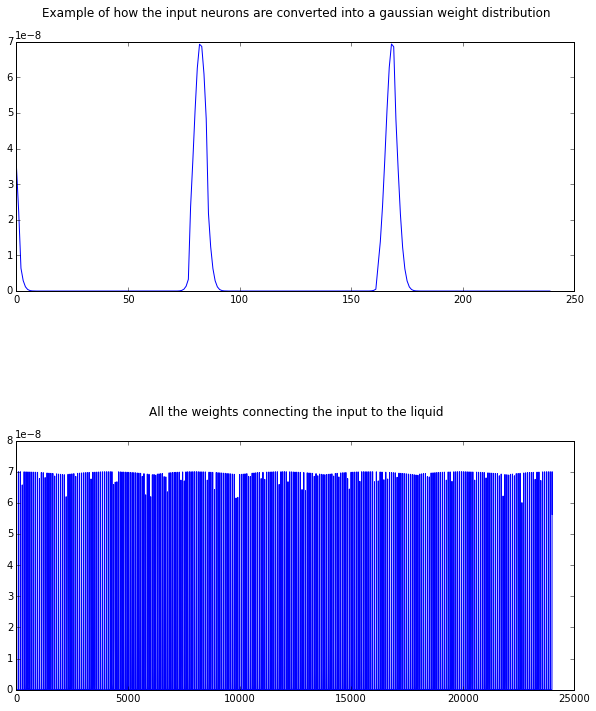

In [76]:
# The weights are created in such a way that 
%matplotlib inline
fig=plt.figure(figsize=(10,10));
plt.subplot(211);
plt.plot(weights_spy[30*len(weights_spy)/6/50:33*len(weights_spy)/6/50])
plt.title("Example of how the input neurons are converted into a gaussian weight distribution",y=1.08)
plt.subplot(212);
plt.plot(weights_spy)
plt.title("All the weights connecting the input to the liquid",y=1.08)
fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.show()

In [77]:
# Filters ONLY the output spikes
output_spikes_simulation=numpy.array([[simulated_values[i][3],simulated_values[i][4]] for i in range(len(simulated_values))])

In [78]:
# Converts the output spikes to be able to plot when they occured
y_plot=[k for i in output_spikes_simulation for j in i[0] for k in j]
x_plot=[i[1][0] for i in output_spikes_simulation for j in i[0] for k in j]

# Converts the input spikes to be able to plot when they occured
y_plot_i = numpy.array([j[0] for i in simulated_values for j in i[2]])
x_plot_i = numpy.array([j[1] for i in simulated_values for j in i[2]])

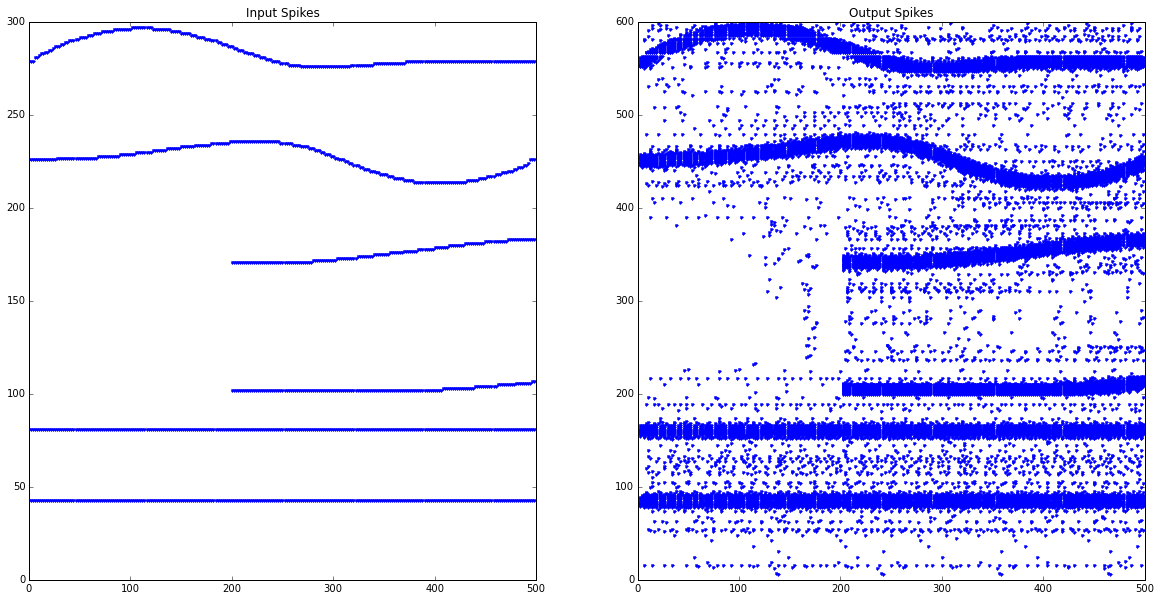

In [79]:
# Plots the inputs and the outputs side-by-side
%matplotlib inline

plt.figure(figsize =(20,10));
plt.subplot(121)
plt.plot(x_plot_i*1000,y_plot_i,'.')
# plt.xlim(-.1,500)
plt.title("Input Spikes")

plt.subplot(122)
plt.plot(x_plot,y_plot,'.')
# plt.xlim(0,100)
plt.title("Output Spikes")


plt.show()